# Gaussian Mixture Models and Expectation Maximization

### GMM of 2 Gaussians

Two Normal distributions $N(μ_1,σ_1^2)$ and $N(μ_2,σ_2^2)$.

There are 5 paramaters to estimate:  $θ = (w,μ_1,σ_1^2,μ_2,σ_2^2)$  

where  $w$  is the probability that the data comes from the first normal probability distribution (and $1- w$ ) it comes from the second normal probability distribution)


The probability density function (PDF) of the mixture model is:


**$$f(x|θ)=w f_1(x | μ_1,σ_1^2)+(1−w) f_2(x | μ_2,σ_2^2)$$**


Objective is to best fit a given probability density by finding  $θ = (w,μ_1,σ_1^2,μ_2,σ_2^2)$  through EM iterations.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform

Generate Gaussian Mixture Model with 2 gaussians

In [8]:
Mean1 = 2
Standard_dev1 = 4 
Mean2 = 12 
Standard_dev2 = 2 

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

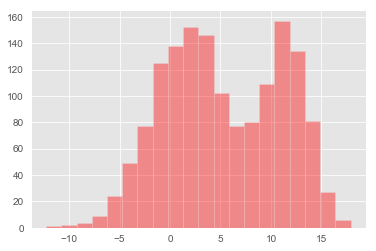

In [19]:
Min_graph = min(data)
Max_graph = max(data)

x = np.linspace(Min_graph, Max_graph, 2000)
sns.distplot(data, bins=20, kde=False, color="red")

### Define Gaussian 

In [15]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

gaussian of best fit:

In [24]:
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: μ = 5.3, σ = 5.7


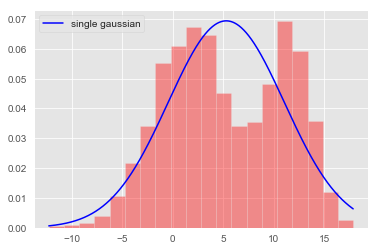

In [25]:
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)

sns.distplot(data, bins=20, kde=False, norm_hist=True, color= "red")
plt.plot(x, g_single, label='single gaussian', color = "blue")

plt.legend();

### Expectation Maximization

EM Alternates between performing:

- **Expectation (E) step:** Given the current parameters of the model, estimate a probability distribution.
- **Maximization (M) step:** Given the current data, estimate the parameters to update the model.

EM, more formally
Alternates between performing:

- **Expectation (E) step:** Using the current estimate for the parameters, create function for the expectation of the log-likelihood.
- **Expectation (E) step:** Computes parameters maximizing the expected log-likelihood found on the E step.

The M parameter-estimates are then used to determine the distribution of the latent variables in the next E step.

**EM is trying to maximize the following function:**
X is directly observed variable
θ parameters of model
Z is not directly observed / latent variable
Z is a joint (related) distribution on x.


**EM Steps**
- Initialize the parameters θ
- Compute the best values for Z given θ
- Use the computed values of Z to compute a better estimate for the θ
- Iterate steps 2 and 3 until convergence

EM steps, stated another way

- Initialize the parameters of the models, either randomly or doing a "smart seeding"
- E Step: Find the posterior probabilities of the latent variable given current parameter values.
- M Step: Reestimate the parameter values given the current posterior probabilities.
- Repeat 2-3 monitoring the likelihood function likelihood. Hope for convergence.

<img src="EM.png">

### Define Gaussian Mixture Model with Expectation Maximization

In [36]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep()

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [38]:
# Check out the fitting process
n_iterations = 10
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

 1 Mixture: Gaussian(-0.136567, 2.64675), Gaussian(9.65736, 3.35766), mix=0.444)
 1 Mixture: Gaussian(0.164438, 2.90441), Gaussian(9.70446, 3.48733), mix=0.461)
 1 Mixture: Gaussian(0.33385, 3.01202), Gaussian(9.8215, 3.46392), mix=0.475)
 1 Mixture: Gaussian(0.453477, 3.07257), Gaussian(9.95843, 3.38796), mix=0.489)
 1 Mixture: Gaussian(0.553738, 3.11513), Gaussian(10.1022, 3.29062), mix=0.502)
 1 Mixture: Gaussian(0.646362, 3.15126), Gaussian(10.2471, 3.18424), mix=0.514)
 1 Mixture: Gaussian(0.735871, 3.18597), Gaussian(10.3899, 3.07479), mix=0.526)
 1 Mixture: Gaussian(0.82372, 3.22142), Gaussian(10.5282, 2.96583), mix=0.538)
 1 Mixture: Gaussian(0.909984, 3.25835), Gaussian(10.6599, 2.86006), mix=0.549)
 1 Mixture: Gaussian(0.994106, 3.29679), Gaussian(10.7832, 2.75981), mix=0.559)


In [50]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))


Computing best model with random restarts...

Best Gaussian Mixture : μ = 1.2e+01, σ = 2.1 with μ = 1.8, σ = 3.8


Show Figure

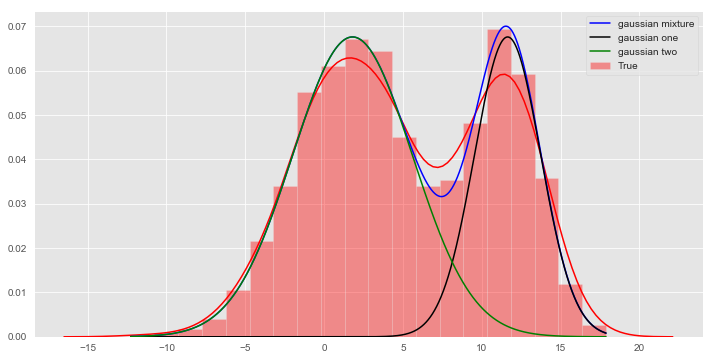

In [61]:
plt.figure(figsize = (12,6))
sns.distplot(data, bins=20, kde=True, norm_hist=True, label= "True", color="r")
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture', color = "b");
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one', color ="black");
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two', color = "green");
plt.legend();